
# Problem Set 3
# Due Sunday, November 22, 2020

<div style="color: #000000;background-color: #FFEEFF">
In this problem set, you are to implement a three-layer (3 layers of weights, 2 hidden layers of units) neural network for binary classification.  All non-linearities are to be sigmoids.

Details are given below.  *Please read the **entire** notebook carefully before proceeding.*

You need to both fill in the necesary code, **and** answer the question at the bottom.</div>

### Enter your information below:

<div style="color: #000000;background-color: #FFCCCC">
    Your Name (submitter): Mohamed Rayyan<br>
Your student ID (submitter): 862037325
</div>

<div style="color: #000000;background-color: #FFCCFF">
    Total Grade: 14/30<br>
    Late Days on this assigment: 0<br>
    Total Late Days so far: <br>
    </div>

In [238]:
# Below are the only imports that are necessary (or allowed)
import numpy as np
import h5py 
import matplotlib.pyplot as plt
import time
from IPython import display

## Data

<div style="color: #000000;background-color: #FFEEFF">
We will be using a USPS digit dataset (provided in the file uspsall73.mat).
It has 16-by-16 grayscale images of each of the 10 different hand-written digits
However, we will load only two of the digits to use as the two classes in
binary classification
</div>

In [239]:
# function to load two of the 10 classes (c1 is for Y=+1 and c2 is for Y=0)
# Note that for neural networks, we will be using Y={+1,0} instead of Y={+1,-1}
def loaddigitdata(c1,c2,m):
    f = h5py.File('uspsall73.mat','r') 
    data = f.get('data') 
    data = np.array(data).astype(float)
    X = np.concatenate((data[c1,:,:],data[c2,:,:]))
    Y = np.concatenate((np.zeros((data.shape[1])),np.ones((data.shape[1]))))
    
    rndstate = np.random.get_state() # going to set the "random" shuffle random seed
    np.random.seed(132857) # setting seed so that dataset is consistent
    p = np.random.permutation(X.shape[0])
    X = X[p] # this and next line make copies, but that's okay given how small our dataset is
    Y = Y[p]
    np.random.set_state(rndstate) # reset seed
    
    trainX = X[0:m,:] # use the first m (after shuffling) for training
    trainY = Y[0:m,np.newaxis]
    validX = X[m:,:] # use the rest for validation
    validY = Y[m:,np.newaxis]
    return (trainX,trainY,validX,validY)

# In case you care (not necessary for the assignment)
def drawexample(x,ax=None): # takes an x *vector* and draws the image it encodes
    if ax is None:
        plt.imshow(np.reshape(x,(16,16)).T,cmap='gray')
    else:
        ax.imshow(np.reshape(x,(16,16)).T,cmap='gray')

In [240]:
# load the data, to differentiate between 7s and 9s
# we will use on 1100 examples for training (50% of the data) and the other half for validation
(trainX,trainY,validX,validY) = loaddigitdata(6,8,1100)
means = trainX.mean(axis=0)
stddevs = trainX.std(axis=0)
stddevs[stddevs<1e-6] = 1.0
trainX = (trainX-means)/stddevs # z-score normalization
validX = (validX-means)/stddevs # apply same transformation to validation set

## WRITE `nneval` and `trainneuralnet` [25 points]

<div style="color: #000000;background-color: #FFFFEE">
This is the main portion of the assignment

Note that the $Y$ values are +1 and 0 (not +1 and -1).  This is as in class for neural networks and works better with a sigmoid output.

You need to write the two functions below (plus any more you would like to add to help): `nneval` and `trainneuralnet`.  The first takes an array/matrix of X vectors and the weights from a neural network and returns a vector of predicted Y values (should be numbers between 0 and 1 -- the probability of class +1, for each of the examples).  The second takes a data set (Xs and Ys), the number of hidden units, and the lambda value (for regularization), and returns the weights.  W1 are the weights from the input to the hidden and W2 are the weights from the hidden to the output.

A few notes:
- **Starting Weights**: The code supplied randomly selects the weights near zero.  https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79 has a reasonable explanation of why we are doing it this way.  But for the purposes of the assignment, you can just accept this is a good way to initialize neural network weights.
- **Offset Terms**: Each layer should have an "offset" or "intercept" unit (to supply a 1 to the next layer), except the output layer.
- **Batch Updates**: For a problem this small, use batch updates.  That is, the step is based on the sum of the gradients for each data point in the training set.
- **Step Size**: http://ruder.io/optimizing-gradient-descent/index.html#gradientdescentoptimizationalgorithms describes a number of methods to adaptively control $\eta$ for fast convergence.  You don't need to understand any of them; however, without them, convergence to good solutions on this problem can be quite slow.  Therefore, *use RMSprop*: the code below has a simple version of RMSprop that is sufficient for this assignment.  You need to supply the code that calculates `sumofgrad2` which should be the sum of the square of each element of the gradient (the squared length of the gradient).  (for debugging, feel free to use a constant $\eta$). 
- **Stopping Criterion**: To determine when to stop, check the loss function every 10 iterations.  If it has not improved by at least $10^{-6}$ over those 10 iterations, stop.
- **Regularization**: You should penalize (from the regularization) all of the weights, even those coming out of offset units.  While it makes sense sometimes not to penalize the ones for the constant $1$ units, you'll find this easier if you just penalize them all.

Tips that might help:
- Display the loss function's value every 10 iterations (or so).  It should be getting smaller.  If not, your gradient is not pointing in the right direction.
- The smaller $\lambda$ is and the more units, the more difficult (longer) the optimization will be.
- Write a function to do forward propagation and one to do backward propagation.  Write a function to evaluate the loss function.  In general, break things up to keep things straight.
- Processing the entire batch at once is more efficient in numpy.  Use numpy broadcasting to avoid loops where possible.
</div>

<div style="color: #000000;background-color: #FFCCFF">
    Grade: 12/25<br>
    Comments:
    </div>

In [599]:
### FEEL FREE TO ADD HELPER FUNCTIONS
def sigmoid(a):
    return np.array([(1 /(1+np.exp(-a)))])

# Wts is whatever object you return from trainneuralnet
def nneval(X,Wts):
    # YOUR CODE HERE
    nn =dict()
    Y =[]
    for i in range(len(X)):
        nn[i] =dict()
        inputt =X[i]
        inputt =np.insert(inputt,0,1)
        for k in range(len(Wts)):
            nn[i][k] =dict()
            nn[i][k]['z'] =np.matmul(inputt,Wts[k].T)
            nn[i][k]['a'] =sigmoid(nn[i][k]['z'])
            nn[i][k]['a'] =np.insert(nn[i][k]['a'], 0, 1)
            inputt =nn[i][k]['a']
        
        Y.append(nn[i][2]['a'][1])
        
    # Should return a vector of values (btwn 0 and 1) for each of the rows of X
    # print(Y)
    return 1-np.array(Y).T
    
    
def losss(X, Y):
    return((-(Y * np.log(X) + (1 - Y) * np.log(1-X))))

def summ(Wts):
    return(np.sum(Wts[0] ** 2) + np.sum(Wts[1] ** 2) + np.sum(Wts[2] ** 2))
    
def evaluateLoss(losses, lossVal):
    losses.append(lossVal)
    if(len(losses) > 10):
        losses.pop(0)
    
    threshold = 10 **(-6)
    
    return(not (abs(losses[0] - lossVal) < threshold) and (losses[0] > lossVal))
    
# Your functions need only work for neural networks of exactly 3 layers of weights
# This training function has a single scalar parameter, nhid, to indicate the number of
# hidden units.  This is the number in the first hidden layer.  The second hidden layer will have 1/2 this number
# You can use "printinfo" to control whether to print out debugging info (or you can just ignore it)
def trainneuralnet(X,Y,nhid,lam,printinfo=False):
    # The number of examples (m) and number of input dimensions (n) of the input data
    (m,n) = X.shape
    
    # This is the code that initializes the weigth matrics:
    # W1 is nhid by n+1 (to map from the input, plus a constant term, to the first hidden layer)
    # W2 is nhid/2 by nhid+1 (to map from the first hidden layer of units to the second)
    # W3 is nhid/2+1 by 1 (to map from the second layers of hidden units to the output)
    W1 = (np.random.rand(nhid,n+1)*2-1)*np.sqrt(6.0/(n+nhid+1)) # weights to each hidden unit from the inputs (plus the added offset unit)
    W2 = (np.random.rand(nhid//2,nhid+1)*2-1)*np.sqrt(6.0/(nhid+nhid/2+1))
    W3 = (np.random.rand(1,nhid//2+1)*2-1)*np.sqrt(6.0/(nhid+2)) # weights to the single output unit from the hidden units (plus the offset unit)
    W2[:,0] = -nhid/2.0
    W3[:,0] = -nhid/4.0
    
    Wts = [W1,W2,W3] # I put them together in a list, but you can use any structure to keep them together and return them in the end
    
    Eg2=1
    # Your loop here:
    nn =dict()
    loss =0
    lwts =0
    lssa =[100]
    count =0
    sumofgrad2 =0
    while(evaluateLoss(lssa, lwts) or (count < 12)):
        lwts =0
        for i in range(m):
            nn[i] =dict()
            inputt =X[i]
            inputt =np.insert(inputt,0,1)
            for k in range(len(Wts)):
                nn[i][k] =dict()
                nn[i][k]['z'] =np.matmul(inputt,Wts[k].T)
                nn[i][k]['a'] =sigmoid(nn[i][k]['z'])
                nn[i][k]['a'] =np.insert(nn[i][k]['a'], 0, 1)
                inputt =nn[i][k]['a']

            nn[i][2]['s'] =(nn[i][2]['a'] -Y[i])
            nn[i][2]['s'] =np.delete(nn[i][2]['s'],0)

            d =nn[i][2]['s'] *Wts[2]
            s =d*nn[i][1]['a']
            s =s*(1-nn[i][1]['a'])
            nn[i][1]['s'] =np.delete(s,0,1)

            d =np.matmul(nn[i][1]['s'],np.delete(Wts[1],0,1))
            s =d *nn[i][0]['a'][1:]
            s =s *(1-nn[i][0]['a'][1:])
            nn[i][0]['s'] =s

            g2 =np.array([nn[i][2]['s'] *nn[i][1]['a']])
            sumofgrad2 =np.sum(g2**2)
            g1 =np.array(nn[i][1]['s'].T *nn[i][0]['a'])
            sumofgrad2 =sumofgrad2 +np.sum(g1**2)
            g0 =np.array(nn[i][0]['s'].T *np.insert(X[i],0,1))
            sumofgrad2 =sumofgrad2 +np.sum(g0**2)

            # in the loop, after calculating the gradient, but before making a step
            # calculate the sum of the squares of all of the gradient values
            # and store it in sumofgrad2
            # then execute this code to get the step size, eta:
            Eg2 = 0.9*Eg2 + 0.1*sumofgrad2
            eta = 0.01/(np.sqrt((1e-10+Eg2)))

            Wts[0] =Wts[0] -(eta*g0)
            Wts[1] =Wts[1] -(eta*g1)
            Wts[2] =Wts[2] -(eta*g2)

            lwts = lwts +  losss(nn[i][2]['a'][1],Y[i])
        
        lwts =(((1/m) * lwts + (lam/m) * summ(Wts))[0])
        
        count =count +1

#         print(lssa)
        
#             print(count)
#             print(lssa, " | ", abs(lssa[0] - lssa[-1]), " | ", 10 ** (-6))

    
    # when done, return your weights
    return Wts



In [600]:
%%time
# Use this cell (or others you add) to check your network
# I would debug on simple examples you create yourself (trying to understand what happens with
#  the full 256-dimensional data is hard)

#an example of training on the USPS data with 32/16 hidden units and lambda=0.1, takes about 9800 iterations and about 50 seconds for the solutions
Wts = trainneuralnet(trainX,trainY,32,0.1,True)

CPU times: user 5.44 s, sys: 986 µs, total: 5.44 s
Wall time: 5.44 s


## Performance plot
<div class="alert alert-info">
The code below will plot your algorithm's error rate on this data set for various regularization strengths and numbers of hidden units.

Make sure your code works for this plot.

My code runs in about 12 minutes (to produce the full plot below)
</div>

CPU times: user 8min 51s, sys: 476 ms, total: 8min 51s
Wall time: 8min 51s


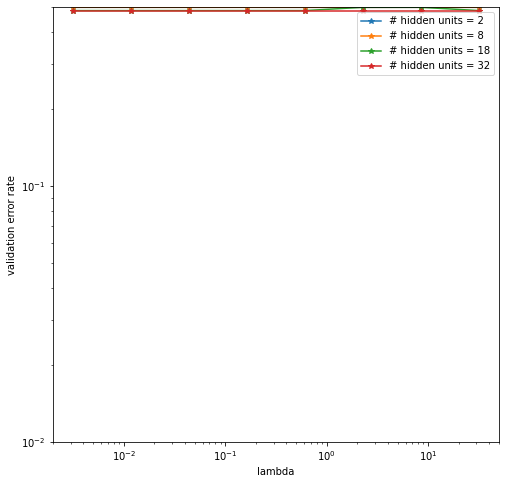

In [601]:
%%time
# This code is given.  Do not modify.
def setupfig():
    f = plt.figure()
    f.set_size_inches(8,8)
    ax = f.add_subplot(111)
    plt.ion()
    f.canvas.draw()
    return (f,ax)

def plotit(lams,nhiddens,erates,f,ax):
    ax.clear()
    for i in range(nhiddens.shape[0]):
        ax.plot(lams,erates[:,i],'*-')
    ax.set_yscale('log',subs=[1,2,3,4,5,6,7,8,9])
    ax.set_yticks([0.1,0.01])
    ax.set_xscale('log')
    f.canvas.draw()
    ax.set_xlabel('lambda')
    ax.set_ylabel('validation error rate')
    ax.legend([(('# hidden units = '+str(x)) if x>0 else 'logistic regression') for x in nhiddens])
    display.display(f)
    display.clear_output(wait=True)
    
def errorrate(Y,predy):
    predy[predy<0.5] = 0.0
    predy[predy>=0.5] = 1.0
    return (predy!=Y).mean()
    
def multirestart(trainX,trainY,nhid,lam,ntries):
    besterrsc = 1.0
    for i in range(ntries):
        Wts = trainneuralnet(trainX,trainY,nhid,lam)
        errsc = errorrate(trainY,nneval(trainX,Wts))
        if errsc<besterrsc:
            returnWts = Wts
            besterrsc = errsc
    return returnWts
    
nhiddens = np.array([0,4,8,16])
nhiddens = np.array([2,8,18,32])
lams = np.logspace(-2.5,1.5,8)
erates = np.empty([lams.shape[0],nhiddens.shape[0]])
erates[:,:] = np.nan

(f,ax) = setupfig()

    
for ni, nhid in enumerate(nhiddens):
    for li, lam in reversed(list(enumerate(lams))):
        if nhid==0:
            w = learnlogreg(trainX,trainY,lam)
            predy = predictlogreg(validX,w)[:,np.newaxis]
        else:
            Wts = multirestart(trainX,trainY,nhid,lam,1) #trainneuralnet(trainX,trainY,nhid,lam)
            predy = nneval(validX,Wts)
        erates[li,ni] = errorrate(validY,predy)
        
        plotit(lams,nhiddens,erates,f,ax)

## INTERPRET the Plot [5 points]
<div style="color: #000000;background-color: #FFFFEE">
How do you interpret the plot above?  How and why does the plot differ by number of hidden units?  By $\lambda$ value?  What parts of this plot agree with the material taught?  What parts do not?
</div>

<div style="color: #000000;background-color: #FFCCFF">
    Grade: 2/5<br>
    Comments: Plot is wrong, explanation has errors. smaller lambda does not neccesarily equate to more accuracy.
    </div>

### Your Answer Here

The plot above measures the performance of a neural network in terms of hideen units and the value of lambda.

The more hidden units there are the more accurate the network is. This is due to more computation is occuring to better approximate the function

The smaller lambda is the more accurate the network is. This is due to when lambda is smaller it would take a smaller step into the wrong direction (if it is going in the wrong direction)

The part of this plot that agree with material taught in class is the smaller the lambda the better and the more hidden units there the better the network is.

